# Exploring ASAP dataset

Dataset of [Aligned Scores and Performances](https://github.com/fosfrancesco/asap-dataset/tree/master)

In [1]:
import sys
sys.path.append("..")

from src.data import extract_piano_roll, calculate_cross_similarity, construct_beat_alignment
from src.utils import plot_piano_roll, plot_cross_similarity, seconds_to_frames
from src.transforms import RandomJumps
from src.asap import load_annotations, ASAPWrapper

import os

import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Path to the clonned ASAP repository

asap_dir = "../../asap-dataset"

In [3]:
annotations = load_annotations(asap_dir)

In [4]:
print(f"Number of performances in ASAP: {len(annotations)}")

Number of performances in ASAP: 1067


Let's take a look at one of the performances of Schubert's Impromptu Op. 90 No. 2

In [5]:
piece_title = 'Schubert/Impromptu_op.90_D.899/2'
performer = 'Denisova11M.mid'
perf_title = os.path.join(piece_title, performer)
perf_path = os.path.join(asap_dir, perf_title)

score_path = os.path.join(asap_dir, piece_title, 'midi_score.mid')

In [6]:
list(annotations[perf_title].keys())

['performance_beats',
 'performance_downbeats',
 'performance_beats_type',
 'perf_time_signatures',
 'perf_key_signatures',
 'midi_score_beats',
 'midi_score_downbeats',
 'midi_score_beats_type',
 'midi_score_time_signatures',
 'midi_score_key_signatures',
 'downbeats_score_map',
 'score_and_performance_aligned']

In [7]:
perf_beats = np.array(annotations[perf_title]['performance_beats'])

print("Number of annotated beats in performance:", len(perf_beats))

Number of annotated beats in performance: 848


In [8]:
score_beats = np.array(annotations[perf_title]['midi_score_beats'])

print("Number of annotated beats in the score:", len(score_beats))

Number of annotated beats in the score: 848


As we can see, the number of annotated beats match.

# Cross-similarity

In [9]:
# Sampling frequency for piano rolls
fs = 40

In [10]:
perf_roll = extract_piano_roll(perf_path, fs=fs)
perf_roll.shape

torch.Size([8934, 128])

/home/dmgvrlv/code/dcnn-alignment/notebooks/../src/utils.py:19: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll.T.numpy()[start_pitch:end_pitch + 1],


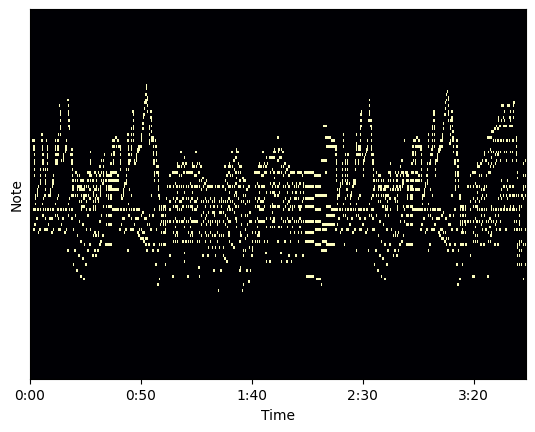

In [11]:
plot_piano_roll(perf_roll, fs)

In [12]:
score_roll = extract_piano_roll(score_path)
score_roll.shape

/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


torch.Size([16959, 128])

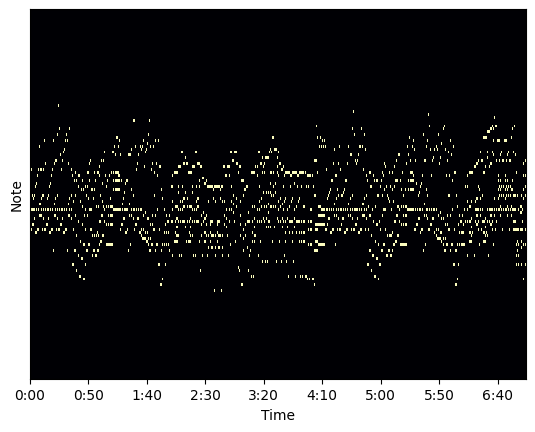

In [13]:
plot_piano_roll(score_roll, fs)

In [14]:
cross_similarity = calculate_cross_similarity(perf_roll, score_roll)
cross_similarity.shape

torch.Size([1, 8934, 16959])

In [15]:
beat_alignment = construct_beat_alignment(perf_beats, score_beats, fs)
beat_alignment.shape

(2, 848)

In [16]:
beat_alignment

array([[   44,    60,    70, ...,  8899,  8910,  8920],
       [    0,    20,    40, ..., 16900, 16920, 16940]])

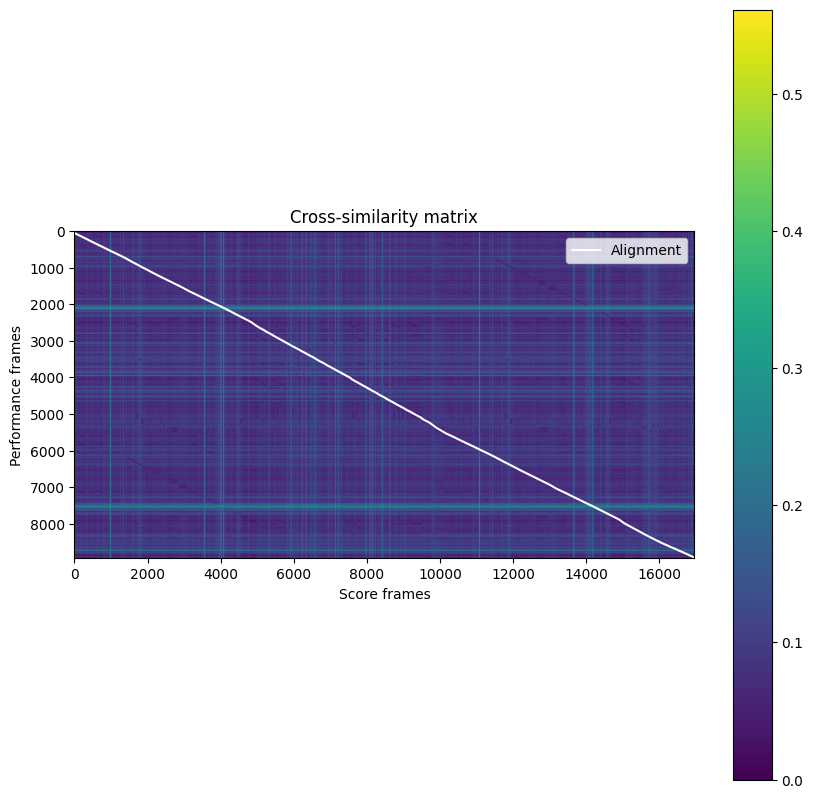

In [17]:
plot_cross_similarity(cross_similarity, beat_alignment=beat_alignment)

In [18]:
cross_similarity

tensor([[[0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
         [0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
         [0.0353, 0.0353, 0.0353,  ..., 0.0725, 0.0725, 0.0725],
         ...,
         [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180],
         [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180],
         [0.0911, 0.0911, 0.0911,  ..., 0.0180, 0.0180, 0.0180]]])

# Augmentations

In [39]:
jumps_transform = RandomJumps(fs, min_num_jumps=0, max_num_jumps=3, max_silence_s=8.)

In [40]:
aug_perf_roll, aug_beat_alignment, inflection_points = jumps_transform(perf_roll, score_roll, beat_alignment)

In [41]:
print(f'Piano roll shape: {perf_roll.shape}')
print(f'Augmented piano roll shape: {aug_perf_roll.shape}')

Piano roll shape: torch.Size([8934, 128])
Augmented piano roll shape: torch.Size([11441, 128])


In [42]:
print(f'Beat alignment shape: {beat_alignment.shape}')
print(f'Augmented beat alignment shape: {aug_beat_alignment.shape}')

Beat alignment shape: (2, 848)
Augmented beat alignment shape: (2, 1040)


In [43]:
beat_alignment

array([[   44,    60,    70, ...,  8899,  8910,  8920],
       [    0,    20,    40, ..., 16900, 16920, 16940]])

In [44]:
aug_beat_alignment

array([[    0,    16,    26, ..., 11361, 11371, 11382],
       [    0,    20,    40, ..., 16880, 16900, 16920]])

In [45]:
inflection_points

tensor([[0.0752, 0.1002],
        [0.0850, 0.0601],
        [0.4471, 0.5154],
        [0.4729, 0.3302],
        [0.0000, 0.0000],
        [0.0000, 0.0000]])

In [46]:
aug_cross_similarity = calculate_cross_similarity(aug_perf_roll, score_roll)
aug_cross_similarity.shape

torch.Size([1, 11441, 16959])

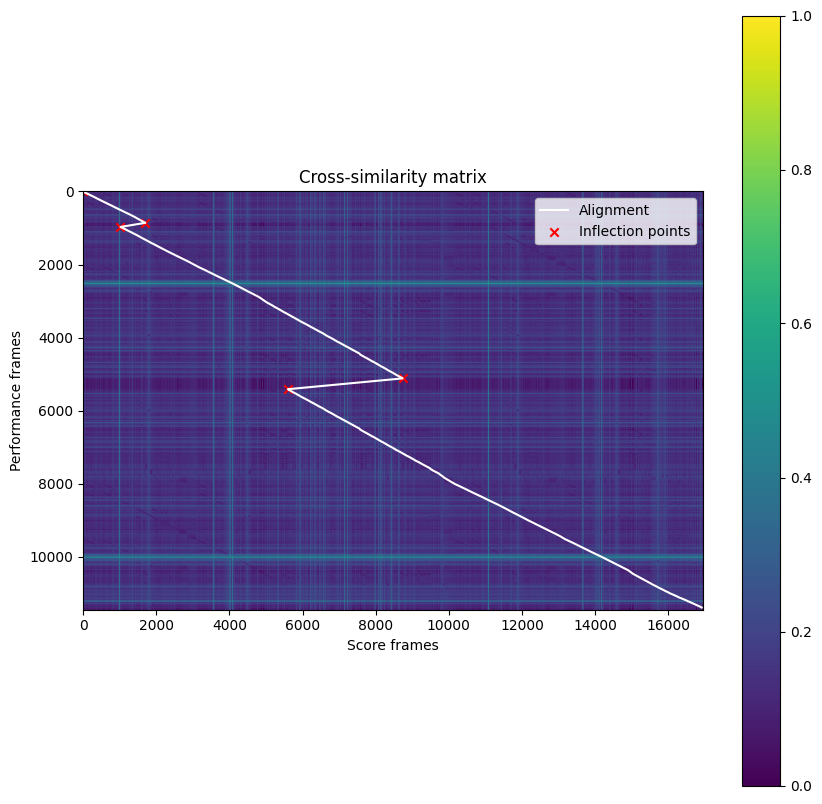

In [47]:
plot_cross_similarity(aug_cross_similarity,
                      beat_alignment=aug_beat_alignment,
                      inflection_points=inflection_points)

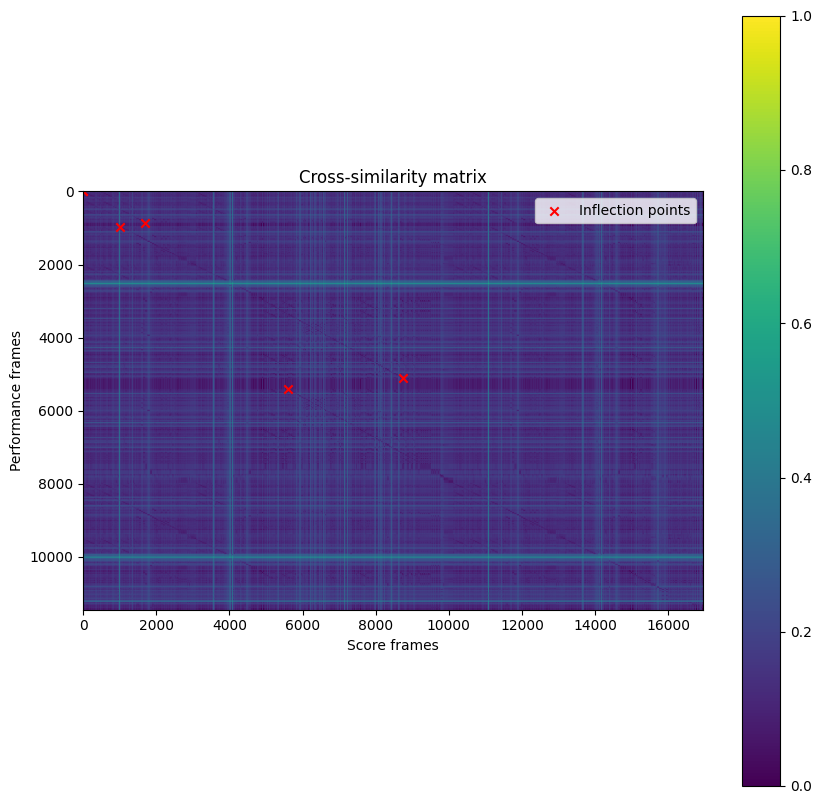

In [48]:
plot_cross_similarity(aug_cross_similarity,
                      beat_alignment=None,
                      inflection_points=inflection_points)

# Dataset

In [49]:
asap_wrapper = ASAPWrapper(asap_dir, val_ratio=0.2, random_seed=42)

In [50]:
print(f'Number of performances in train: {len(asap_wrapper.train_paths)}')
print(f'Number of performances in val: {len(asap_wrapper.val_paths)}')

Number of performances in train: 801
Number of performances in val: 235


In [51]:
from typing import List, Dict, Optional, Callable
from torch.utils.data import Dataset


class CrossSimilarityDataset(Dataset):
    """Performance-score cross-similarity matrices dataset."""

    def __init__(self,
                 pairs: List[Dict],
                 fs: int,
                 transform: Callable,
                 structural_transform: Optional[Callable] = None,
                 inference_only: bool = False):
        """Initializes an instance of dataset class.

        Args:
            pairs: A list of performance-score path pairs and (optionally) their aligned
              beat arrays. Each dictionary in a list must contain keys `perf`, `score`.
              If `structural_transform` is not None, then `perf_beats`, and `score_beats`
              must also be keys.
            fs: Piano roll sampling frequency.
            transform: Transformation to apply to cross-similarity matrices (e.g., resize).
            structural_transform: Structural transformations to apply to performance
              piano rolls.
            inference_only: If True, dataset does not contain ground truth inflection points.
        """
        self.pairs = pairs
        self.fs = fs
        self.transform = transform
        self.structural_transform = structural_transform
        self.inference_only = inference_only

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        perf_path = self.pairs[idx]['perf']
        score_path = self.pairs[idx]['score']
        if self.structural_transform is not None:
            perf_beats = np.array(self.pairs[idx]['perf_beats'])
            score_beats = np.array(self.pairs[idx]['score_beats'])

        perf_roll = extract_piano_roll(perf_path, fs=fs)
        score_roll = extract_piano_roll(score_path, fs=fs)

        if self.structural_transform is not None:
            beat_alignment = construct_beat_alignment(perf_beats, score_beats, fs)
            perf_roll, beat_alignment, inflection_points = self.structural_transform(perf_roll, score_roll, beat_alignment)

        cross_similarity = calculate_cross_similarity(perf_roll, score_roll)
        cross_similarity = self.transform(cross_similarity)
        sample = {'image': cross_similarity}

        if not self.inference_only:
            sample['target'] = inflection_points

        return sample

In [52]:
from torchvision.transforms.v2 import Resize

img_size = 1024
transform = Resize((img_size, img_size))
jumps_transform = RandomJumps(fs, min_num_jumps=0, max_num_jumps=3, max_silence_s=8.)

train_dataset = CrossSimilarityDataset(asap_wrapper.train_paths,
                                       fs,
                                       transform,
                                       structural_transform=jumps_transform,
                                       inference_only=False)

In [53]:
train_dataset[0]

/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(anti

{'image': tensor([[[0.0356, 0.0356, 0.0356,  ..., 0.1968, 0.1968, 0.1968],
          [0.0228, 0.0228, 0.0228,  ..., 0.2021, 0.2021, 0.2021],
          [0.0228, 0.0228, 0.0228,  ..., 0.2021, 0.2021, 0.2021],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2009, 0.2009, 0.2009],
          [0.0000, 0.0000, 0.0000,  ..., 0.2009, 0.2009, 0.2009],
          [0.0000, 0.0000, 0.0000,  ..., 0.2009, 0.2009, 0.2009]]]),
 'target': tensor([[0.4421, 0.6670],
         [0.4769, 0.2686],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]])}

In [54]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [55]:
for batch in train_loader:
    x = batch['image']
    target = batch['target']
    print(x.shape)
    print(target.shape)
    break

torch.Size([8, 1, 1024, 1024])
torch.Size([8, 6, 2])
